# 프로젝트 : CIFAR-10 이미지 생성하기


GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.
우선 주요 라이브러리 버전을 확인하고 진행합시다.

In [22]:
# python env: img
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
import numpy as np
import warnings
from tensorflow.keras import layers

warnings.filterwarnings('ignore')

print(tf.__version__)
print(imageio.__version__)

2.11.0
2.24.0


## STEP 1. 작업환경 구성하기

다음과 같이 작업환경을 구성합시다.

```
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history
```

## STEP 2. 데이터셋 구성하기

CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.

In [5]:
print(train_x.max(), train_x.min())

train_x = (train_x - 127.5) / 127.5
print(train_x.max(), train_x.min())

1.0 -1.0
-0.9921568627450981 -1.007843137254902


- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.


In [6]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

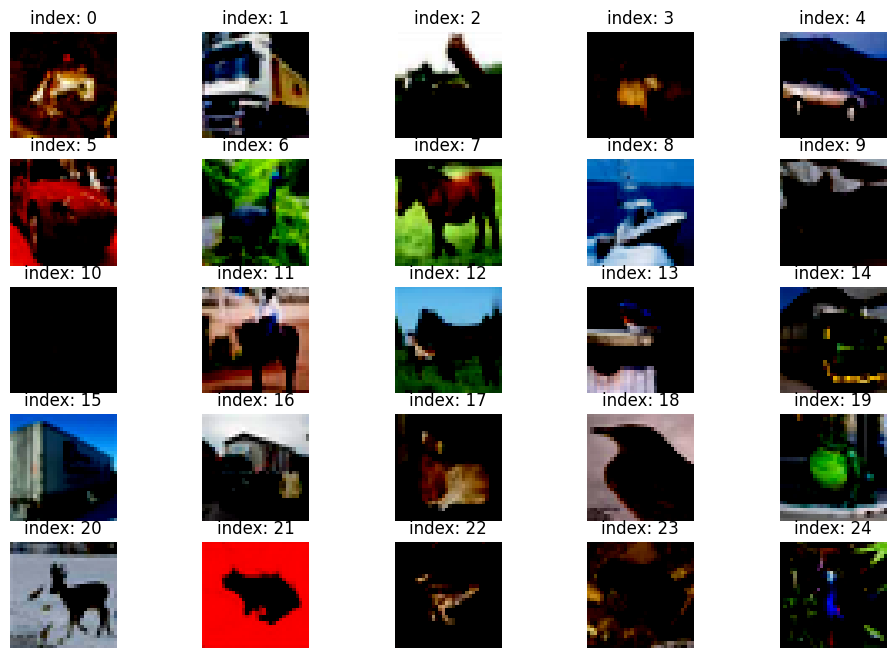

In [43]:
plt.figure(figsize = (12, 8))
for i in range(25):
    plt.subplot(5,5,i+1)
    with warnings.catch_warnings():
        plt.imshow(train_x[i].reshape(32,32,3))
    plt.title('index: ' + str(i))
    plt.axis('off')
plt.show()

- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.
- 학습 시간이 너무 오래 걸린다면 한 종류의 데이터만 추출해 진행해도 좋습니다. 아래 코드는 참고만 하세요.

In [7]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-01-22 15:31:19.682002: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-22 15:31:19.682629: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



#------<참고>----------
```python
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x
```

# STEP 3. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [18]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*768, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 768)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(384, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(192, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [19]:
generator = make_generator_model()

generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 49152)             4915200   
                                                                 
 batch_normalization_7 (Batc  (None, 49152)            196608    
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 49152)             0         
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 768)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 8, 8, 384)        7372800   
 ranspose)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 384)       

In [10]:
noise = tf.random.normal([1, 100])

In [20]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

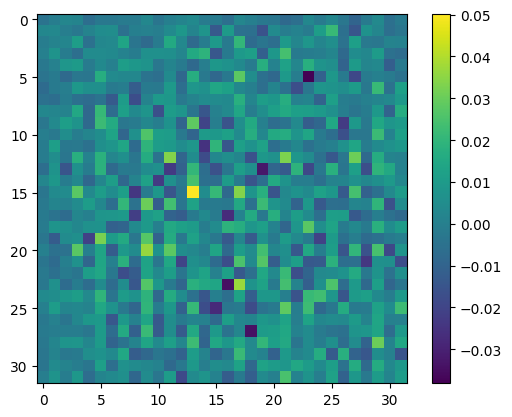

In [24]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

In [31]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(192, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(384, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(3))

    return model

In [32]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 192)       14592     
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 16, 16, 192)       0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 192)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 384)         1843584   
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 8, 8, 384)         0         
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 384)         0         
                                                                 
 flatten_1 (Flatten)         (None, 24576)            

In [33]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.00208494,  0.00120935,  0.00193119]], dtype=float32)>